https://www.tensorflow.org/tutorials/keras/regression

在 回归 (regression) 问题中，我们的目的是预测出如价格或概率这样连续值的输出。相对于分类(classification) 问题，分类(classification) 的目的是从一系列的分类出选择出一个分类 （如，给出一张包含苹果或橘子的图片，识别出图片中是哪种水果）。

本 notebook 使用经典的 Auto MPG 数据集，构建了一个用来预测70年代末到80年代初汽车燃油效率的模型。为了做到这一点，我们将为该模型提供许多那个时期的汽车描述。这个描述包含：气缸数，排量，马力以及重量。

本示例使用 tf.keras API，相关细节请参阅 本指南。

In [2]:
# 使用 seaborn 绘制矩阵图 (pairplot)
!pip install -q seaborn

In [3]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


# Auto MPG 数据集
该数据集可以从 UCI机器学习库 中获取.

**获取数据**

首先下载数据集。

In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
print(dataset_path)

32768/30286 [================================] - 0s 1us/step
/root/.keras/datasets/auto-mpg.data


使用 pandas 导入数据集。

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
print(dataset.tail())

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1  


# 数据清洗
数据集中包括一些未知值。

In [6]:
print(dataset.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


为了保证这个初始示例的简单性，删除这些行。

In [7]:
dataset = dataset.dropna()

"Origin" 列实际上代表分类，而不仅仅是一个数字。所以把它转换为独热码 （one-hot）:

In [8]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
print(dataset.tail())

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


# 拆分训练数据集和测试数据集
现在需要将数据集拆分为一个训练数据集和一个测试数据集。

我们最后将使用测试数据集对模型进行评估。

In [9]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# 数据检查
快速查看训练集中几对列的联合分布。

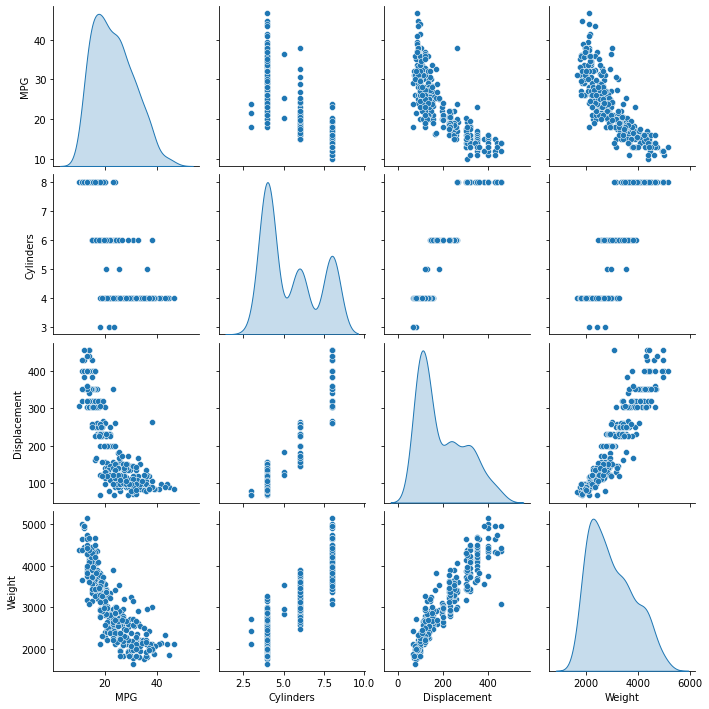

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

也可以查看总体的数据统计:

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
print(train_stats)

              count         mean         std     min      25%     50%  \
Cylinders     314.0     5.477707    1.699788     3.0     4.00     4.0   
Displacement  314.0   195.318471  104.331589    68.0   105.50   151.0   
Horsepower    314.0   104.869427   38.096214    46.0    76.25    94.5   
Weight        314.0  2990.251592  843.898596  1649.0  2256.50  2822.5   
Acceleration  314.0    15.559236    2.789230     8.0    13.80    15.5   
Model Year    314.0    75.898089    3.675642    70.0    73.00    76.0   
USA           314.0     0.624204    0.485101     0.0     0.00     1.0   
Europe        314.0     0.178344    0.383413     0.0     0.00     0.0   
Japan         314.0     0.197452    0.398712     0.0     0.00     0.0   

                  75%     max  
Cylinders        8.00     8.0  
Displacement   265.75   455.0  
Horsepower     128.00   225.0  
Weight        3608.00  5140.0  
Acceleration    17.20    24.8  
Model Year      79.00    82.0  
USA              1.00     1.0  
Europe       

# 从标签中分离特征
将特征值从目标值或者"标签"中分离。 这个标签是你使用训练模型进行预测的值

In [12]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

# 数据规范化
再次审视下上面的 train_stats 部分，并注意每个特征的范围有什么不同。

使用不同的尺度和范围对特征归一化是好的实践。尽管模型可能 在没有特征归一化的情况下收敛，它会使得模型训练更加复杂，并会造成生成的模型依赖输入所使用的单位选择。

注意：尽管我们仅仅从训练集中有意生成这些统计数据，但是这些统计信息也会用于归一化的测试数据集。我们需要这样做，将测试数据集放入到与已经训练过的模型相同的分布中。

In [13]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

我们将会使用这个已经归一化的数据来训练模型。

**警告**: 用于归一化输入的数据统计（均值和标准差）需要反馈给模型从而应用于任何其他数据，以及我们之前所获得独热码。这些数据包含测试数据集以及生产环境中所使用的实时数据。

# 模型
## 构建模型
让我们来构建我们自己的模型。这里，我们将会使用一个“顺序”模型，其中包含两个紧密相连的隐藏层，以及返回单个、连续值得输出层。模型的构建步骤包含于一个名叫 'build_model' 的函数中，稍后我们将会创建第二个模型。 两个密集连接的隐藏层。

In [15]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
None


现在试用下这个模型。从训练数据中批量获取‘10’条例子并对这些例子调用 model.predict 。

In [16]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
print(example_result)

[[ 0.06771523]
 [-0.03838539]
 [-0.38267744]
 [-0.03064618]
 [-0.38976038]
 [ 0.09478177]
 [-0.47744995]
 [-0.32158267]
 [ 0.18360698]
 [-0.39631027]]


它似乎在工作，并产生了预期的形状和类型的结果

# 训练模型
对模型进行1000个周期的训练，并在 history 对象中记录训练和验证的准确性。

In [17]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
................................................................................................
....................................................................................................
....................................................................................................
..............................................................................................

使用 history 对象中存储的统计信息可视化模型的训练进度。

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())

         loss       mae       mse  val_loss   val_mae   val_mse  epoch
995  2.399043  0.973907  2.399043  8.996450  2.327849  8.996450    995
996  2.411803  0.963031  2.411803  8.296998  2.197323  8.296998    996
997  2.522472  1.008659  2.522472  8.251726  2.212490  8.251726    997
998  2.593006  1.010022  2.593006  8.491447  2.187291  8.491447    998
999  2.462464  0.995788  2.462464  8.416249  2.238927  8.416249    999


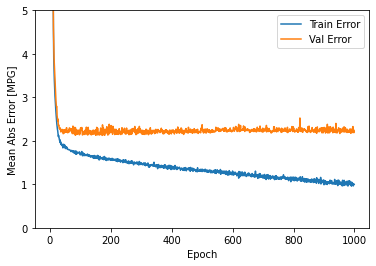

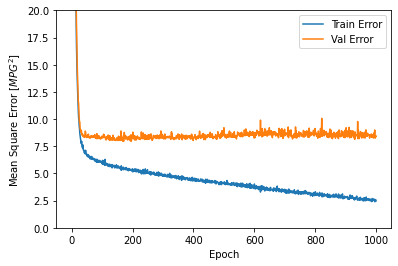

In [19]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

该图表显示在约100个 epochs 之后误差非但没有改进，反而出现恶化。 让我们更新 model.fit 调用，当验证值没有提高上是自动停止训练。 我们将使用一个 EarlyStopping callback 来测试每个 epoch 的训练条件。如果经过一定数量的 epochs 后没有改进，则自动停止训练。

你可以从这里学习到更多的回调。


...................................................

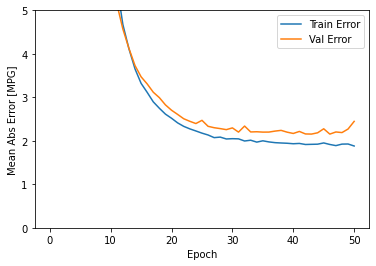

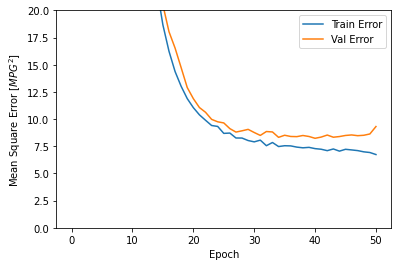

In [20]:
model = build_model()

# patience 值用来检查改进 epochs 的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

如图所示，验证集中的平均的误差通常在 +/- 2 MPG左右。 这个结果好么？ 我们将决定权留给你。

让我们看看通过使用 测试集 来泛化模型的效果如何，我们在训练模型时没有使用测试集。这告诉我们，当我们在现实世界中使用这个模型时，我们可以期望它预测得有多好。

In [21]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.8255 - mae: 1.8971 - mse: 6.8255
Testing set Mean Abs Error:  1.90 MPG


# 做预测
最后，使用测试集中的数据预测 MPG 值:

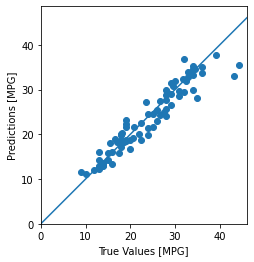

In [22]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

这看起来我们的模型预测得相当好。我们来看下误差分布。

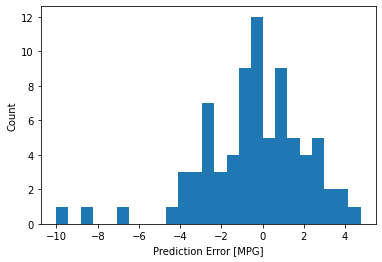

In [23]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

它不是完全的高斯分布，但我们可以推断出，这是因为样本的数量很小所导致的。

# 结论
本笔记本 (notebook) 介绍了一些处理回归问题的技术。

* 均方误差（MSE）是用于回归问题的常见损失函数（分类问题中使用不同的损失函数）。
* 类似的，用于回归的评估指标与分类不同。 常见的回归指标是平均绝对误差（MAE）。
* 当数字输入数据特征的值存在不同范围时，每个特征应独立缩放到相同范围。
* 如果训练数据不多，一种方法是选择隐藏层较少的小网络，以避免过度拟合。
* 早期停止是一种防止过度拟合的有效技术。